## Importing libraries

In [1]:
# loading data
import urllib.request

# data manipulation
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
# enable interactive plot in the notebook
%matplotlib notebook

# machine learning methods
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

## Loading and formatting the data

In [2]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/undergroundWater?station_id=85040";
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
df = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
df['Date'] = df['LastUpdatedEpoch'];
df['Date'] = pd.to_datetime(df['Date'], unit='ms');

# remove unneccessary fields
df.drop('LastUpdated', 1, inplace=True);
df.drop('LastUpdatedEpoch', 1, inplace=True);
df.drop('Region_id', 1, inplace=True);
df.drop('Region_name', 1, inplace=True);
df.drop('Station_id', 1, inplace=True);
df.drop('Station_name', 1, inplace=True);
df.drop('SystemCodeNumber', 1, inplace=True);

## Checking loaded data

In [3]:
# string/tabular view
# len(jsonStr), jsonStr[0:100] and df[0:5]
df[0:5]

,Value,Date
0,275.11,1973-01-01
1,275.08,1973-01-02
2,275.05,1973-01-03
3,275.03,1973-01-04
4,275.00,1973-01-05


<IPython.core.display.Javascript object>


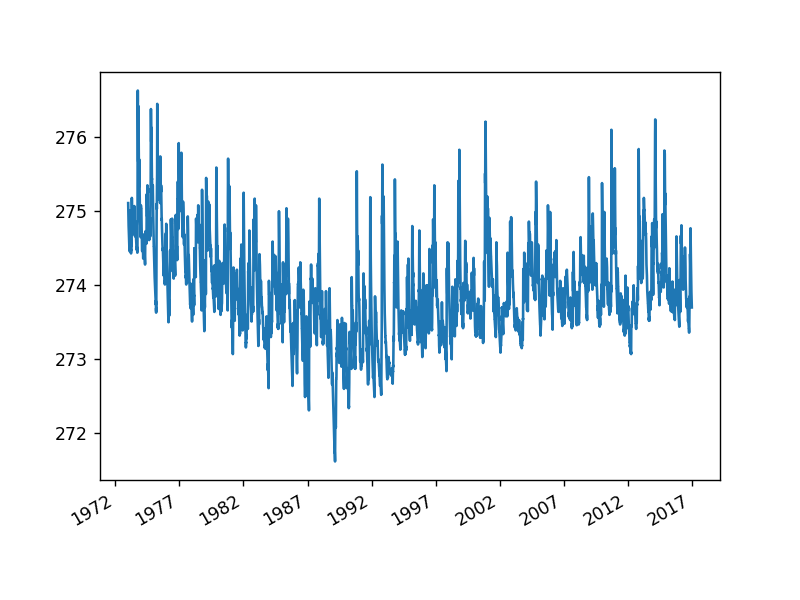

In [4]:
# plotting the data
# format date axis
fig, ax = plt.subplots(); fig.autofmt_xdate();
# plot
ax.plot(df['Date'], df['Value']);
# show plot
plt.show();

## Loading some additional data for modeling (weather)

In [5]:
pd.set_option('display.max_rows', 5000)
df['Date']

0       1973-01-01
1       1973-01-02
2       1973-01-03
3       1973-01-04
4       1973-01-05
5       1973-01-06
6       1973-01-07
7       1973-01-08
8       1973-01-09
9       1973-01-10
10      1973-01-11
11      1973-01-12
12      1973-01-13
13      1973-01-14
14      1973-01-15
15      1973-01-16
16      1973-01-17
17      1973-01-18
18      1973-01-19
19      1973-01-20
20      1973-01-21
21      1973-01-22
22      1973-01-23
23      1973-01-24
24      1973-01-25
25      1973-01-26
26      1973-01-27
27      1973-01-28
28      1973-01-29
29      1973-01-30
30      1973-01-31
31      1973-02-01
32      1973-02-02
33      1973-02-03
34      1973-02-04
35      1973-02-05
36      1973-02-06
37      1973-02-07
38      1973-02-08
39      1973-02-09
40      1973-02-10
41      1973-02-11
42      1973-02-12
43      1973-02-13
44      1973-02-14
45      1973-02-15
46      1973-02-16
47      1973-02-17
48      1973-02-18
49      1973-02-19
50      1973-02-20
51      1973-02-21
52      1973

In [6]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/weather?time_from=31/12/2009&time_to=01/01/2017&city=Ljubljana";
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
dw = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
dw['Date'] = dw['LastUpdatedEpoch'];
dw['Date'] = pd.to_datetime(dw['Date'] + 2 * 60 * 60 * 1000, unit='ms').dt.round("1d");
dw.set_index('Date', inplace=True);

dw.drop('City', 1, inplace=True);
dw.drop('LastUpdated', 1, inplace=True);
dw.drop('LastUpdatedEpoch', 1, inplace=True);
dw.drop('Sensor_id', 1, inplace=True);
dw.drop('Sensor_name', 1, inplace=True);
dw.drop('SystemCodeNumber', 1, inplace=True);


In [7]:
dw[0:5]

,CloudCover,New_snow_blanket,Percipitation,Snow_blanket,Sun_duration,TemperatureAvg,TemperatureMax,TemperatureMin
Date,,,,,,,,
2010-01-01,97,0,13.8,0,0.0,6.9,7.7,5.5
2010-01-02,100,0,4.6,0,0.0,2.5,6.7,0.7
2010-01-03,7,0,7.9,0,8.0,-0.5,3.4,-2.6
2010-01-04,77,0,0.0,0,0.8,-3.3,-1.6,-6.4
2010-01-05,100,10,5.8,10,0.0,-1.5,-0.5,-2.3


## Data Fusion

In [8]:
# make date a key in our data
df.set_index('Date', inplace=True);

In [9]:
df[0:5]

,Value
Date,
1973-01-01,275.11
1973-01-02,275.08
1973-01-03,275.05
1973-01-04,275.03
1973-01-05,275.00


In [10]:
# generate fused dataset
ds = pd.concat([df, dw], axis=1);

In [11]:
ds = ds.loc['2015-01-01':'2017-01-01']

In [60]:
# let's check it
ds[0:10]

,Value,CloudCover,New_snow_blanket,Percipitation,Snow_blanket,Sun_duration,TemperatureAvg,TemperatureMax,TemperatureMin,DValue
Date,,,,,,,,,,
2015-01-01,274.30,70.0,0.0,0.0,13.0,2.1,-5.8,-3.0,-9.6,NaN
2015-01-02,274.28,83.0,0.0,0.0,12.0,2.1,-0.6,1.5,-5.5,-0.02
2015-01-03,274.24,80.0,0.0,0.0,10.0,0.0,-1.0,0.6,-4.5,-0.04
2015-01-04,274.21,20.0,0.0,0.2,8.0,7.9,3.1,10.3,-0.5,-0.03
2015-01-05,274.18,50.0,0.0,0.0,4.0,5.9,3.0,8.5,0.0,-0.03
2015-01-06,274.16,33.0,0.0,0.0,3.0,4.4,-0.4,4.9,-3.6,-0.02
2015-01-07,274.14,50.0,0.0,0.0,3.0,1.1,-0.9,2.7,-2.7,-0.02
2015-01-08,274.12,83.0,0.0,0.0,3.0,0.2,0.2,2.3,-4.1,-0.02
2015-01-09,274.11,90.0,0.0,0.0,2.0,0.6,4.9,7.5,1.0,-0.01


# .........

In [13]:
ds['DValue'] = ds['Value'] - ds['Value'].shift(1)

In [14]:
#dnew = ds
#for i in range(26):
#    dnew['Sun_duration' + '_shift_' + str(i)+'d'] = ds['Sun_duration'].shift(i)
#for i in range(50,101,10):
#    dnew['Sun_duration' + '_shift_' + str(i)+'d'] = ds['Sun_duration'].shift(i)

In [15]:
#shift of data for n days
def shift_of_data(string, data, new_data):
    for i in range(26):
        new_data[string + '_shift_' + str(i)+'d'] = data[string].shift(i)
    for i in range(30,101,10):
        new_data[string + '_shift_' + str(i)+'d'] = data[string].shift(i)

In [16]:
import copy
dnew = copy.deepcopy(ds)

data_names = ['CloudCover', 'New_snow_blanket', 'Percipitation','Snow_blanket',
              'Sun_duration', 'TemperatureAvg', 'TemperatureMax', 'TemperatureMin']

for string in data_names:
    shift_of_data(string, ds, dnew)

In [17]:
dnew

,Value,CloudCover,New_snow_blanket,Percipitation,Snow_blanket,Sun_duration,TemperatureAvg,TemperatureMax,TemperatureMin,DValue,...,TemperatureMin_shift_24d,TemperatureMin_shift_25d,TemperatureMin_shift_30d,TemperatureMin_shift_40d,TemperatureMin_shift_50d,TemperatureMin_shift_60d,TemperatureMin_shift_70d,TemperatureMin_shift_80d,TemperatureMin_shift_90d,TemperatureMin_shift_100d
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,274.30,70.0,0.0,0.0,13.0,2.1,-5.8,-3.0,-9.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,274.28,83.0,0.0,0.0,12.0,2.1,-0.6,1.5,-5.5,-0.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,274.24,80.0,0.0,0.0,10.0,0.0,-1.0,0.6,-4.5,-0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,274.21,20.0,0.0,0.2,8.0,7.9,3.1,10.3,-0.5,-0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,274.18,50.0,0.0,0.0,4.0,5.9,3.0,8.5,0.0,-0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,274.16,33.0,0.0,0.0,3.0,4.4,-0.4,4.9,-3.6,-0.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,274.14,50.0,0.0,0.0,3.0,1.1,-0.9,2.7,-2.7,-0.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,274.12,83.0,0.0,0.0,3.0,0.2,0.2,2.3,-4.1,-0.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09,274.11,90.0,0.0,0.0,2.0,0.6,4.9,7.5,1.0,-0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
dnew.corr()

,Value,CloudCover,New_snow_blanket,Percipitation,Snow_blanket,Sun_duration,TemperatureAvg,TemperatureMax,TemperatureMin,DValue,...,TemperatureMin_shift_24d,TemperatureMin_shift_25d,TemperatureMin_shift_30d,TemperatureMin_shift_40d,TemperatureMin_shift_50d,TemperatureMin_shift_60d,TemperatureMin_shift_70d,TemperatureMin_shift_80d,TemperatureMin_shift_90d,TemperatureMin_shift_100d
Value,1.000000,0.067413,-0.036783,0.012796,-0.065023,-0.081950,-0.206296,-0.201516,-0.210423,0.058556,...,-0.276032,-0.280883,-0.298158,-0.333679,-0.381280,-0.359914,-0.293439,-0.287466,-0.253708,-0.201380
CloudCover,0.067413,1.000000,0.122452,0.219788,0.162879,-0.832740,-0.315040,-0.429054,-0.138423,0.228394,...,-0.173422,-0.166982,-0.119626,-0.112790,-0.065826,-0.011018,0.005857,0.032737,0.060471,0.078929
New_snow_blanket,-0.036783,0.122452,1.000000,0.182088,0.518093,-0.111978,-0.162496,-0.171834,-0.143569,0.001990,...,-0.139878,-0.128508,-0.123973,-0.103793,-0.059714,-0.067943,-0.050597,-0.022405,0.000624,-0.030393
Percipitation,0.012796,0.219788,0.182088,1.000000,0.029835,-0.178188,-0.010982,-0.044188,0.062845,0.456209,...,0.053165,0.021458,0.015628,0.028124,0.040628,0.011282,0.010889,-0.026575,0.007282,-0.050968
Snow_blanket,-0.065023,0.162879,0.518093,0.029835,1.000000,-0.178759,-0.305313,-0.317375,-0.294889,-0.034235,...,-0.197011,-0.201968,-0.231135,-0.232043,-0.065711,-0.087937,-0.050658,-0.043067,0.028343,-0.007481
Sun_duration,-0.081950,-0.832740,-0.111978,-0.178188,-0.178759,1.000000,0.596189,0.683709,0.407157,-0.150076,...,0.356407,0.348565,0.285265,0.219850,0.155838,0.056702,-0.025394,-0.114992,-0.196478,-0.267138
TemperatureAvg,-0.206296,-0.315040,-0.162496,-0.010982,-0.305313,0.596189,1.000000,0.979318,0.957507,-0.035396,...,0.714557,0.706291,0.643605,0.588929,0.433107,0.329767,0.167204,0.033856,-0.164478,-0.289784
TemperatureMax,-0.201516,-0.429054,-0.171834,-0.044188,-0.317375,0.683709,0.979318,1.000000,0.906927,-0.062084,...,0.695485,0.688403,0.623542,0.568491,0.421246,0.304561,0.156162,0.020409,-0.160841,-0.291403
TemperatureMin,-0.210423,-0.138423,-0.143569,0.062845,-0.294889,0.407157,0.957507,0.906927,1.000000,0.012888,...,0.717036,0.713130,0.665200,0.622597,0.462529,0.380717,0.229227,0.091839,-0.113400,-0.232108
DValue,0.058556,0.228394,0.001990,0.456209,-0.034235,-0.150076,-0.035396,-0.062084,0.012888,1.000000,...,-0.028168,-0.023643,-0.008979,-0.021359,-0.011139,0.033978,0.060157,-0.009863,0.052550,0.011865


In [19]:
#correlation for shifts
#plt.matshow(dnew.corr())

In [20]:
#average for last n days
def average_last_n_days(string, data, new_data):
    for i in range(26):
        new_data[string + '_average_' + str(i)+'d'] = data[string].rolling(i).sum()/i
    for i in range(30,101,10):
        new_data[string + '_average_' + str(i)+'d'] = data[string].rolling(i).sum()/i

In [21]:
#for i in range(26):
#    dnew['Sun_duration' + '_sum_' + str(i)+'d'] = ds['Sun_duration'].rolling(i).sum()

In [22]:
#data_names = ['CloudCover', 'New_snow_blanket', 'Percipitation','Snow_blanket',
#              'Sun_duration', 'TemperatureAvg', 'TemperatureMax', 'TemperatureMin']

#dnew2 = copy.deepcopy(ds)
for string in data_names:
    average_last_n_days(string, ds, dnew)  

In [23]:
#dnew2.corr()

<IPython.core.display.Javascript object>


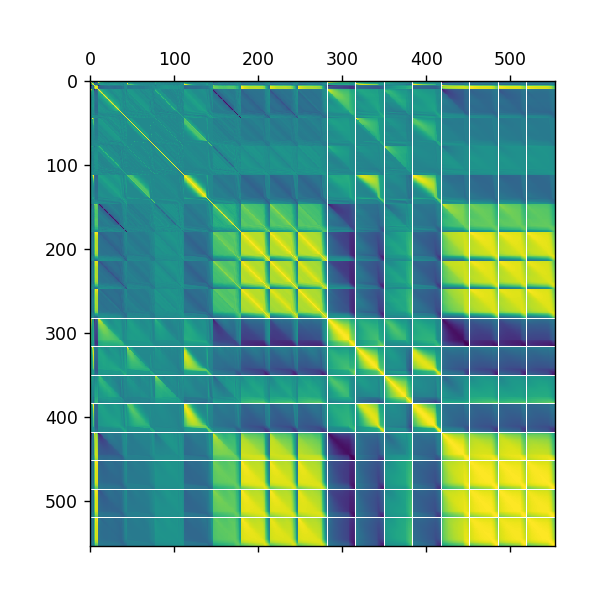

In [24]:
# correlation for shifts and average
plt.matshow(dnew.corr())

In [25]:
dnew.corr()['DValue']

Value                            0.058556
CloudCover                       0.228394
New_snow_blanket                 0.001990
Percipitation                    0.456209
Snow_blanket                    -0.034235
Sun_duration                    -0.150076
TemperatureAvg                  -0.035396
TemperatureMax                  -0.062084
TemperatureMin                   0.012888
DValue                           1.000000
CloudCover_shift_0d              0.228394
CloudCover_shift_1d              0.305120
CloudCover_shift_2d              0.349088
CloudCover_shift_3d              0.288728
CloudCover_shift_4d              0.193496
CloudCover_shift_5d              0.143535
CloudCover_shift_6d              0.116411
CloudCover_shift_7d              0.097115
CloudCover_shift_8d              0.083189
CloudCover_shift_9d              0.067927
CloudCover_shift_10d             0.050957
CloudCover_shift_11d             0.038379
CloudCover_shift_12d             0.035982
CloudCover_shift_13d             0

In [26]:
# sort for corelation with 'DValue' from max to min
dsort = dnew.corr().sort_values(['DValue'], ascending = False)

In [27]:
pd.set_option('display.max_rows', 1000)
dsort['DValue']

DValue                           1.000000
Percipitation_average_3d         0.733892
Percipitation_average_4d         0.705788
Percipitation_average_2d         0.667111
Percipitation_average_5d         0.647093
Percipitation_average_6d         0.591067
Percipitation_shift_1d           0.559022
Percipitation_average_7d         0.544340
Percipitation_average_8d         0.505838
Percipitation_average_9d         0.477534
Percipitation_shift_0d           0.456209
Percipitation_average_1d         0.456209
Percipitation                    0.456209
Percipitation_average_10d        0.439610
Percipitation_average_11d        0.404674
Percipitation_shift_2d           0.398863
CloudCover_average_4d            0.391910
CloudCover_average_5d            0.385569
Percipitation_average_12d        0.378467
CloudCover_average_6d            0.371373
CloudCover_average_3d            0.366996
Percipitation_average_13d        0.362481
CloudCover_average_7d            0.356062
Percipitation_average_14d        0

<IPython.core.display.Javascript object>


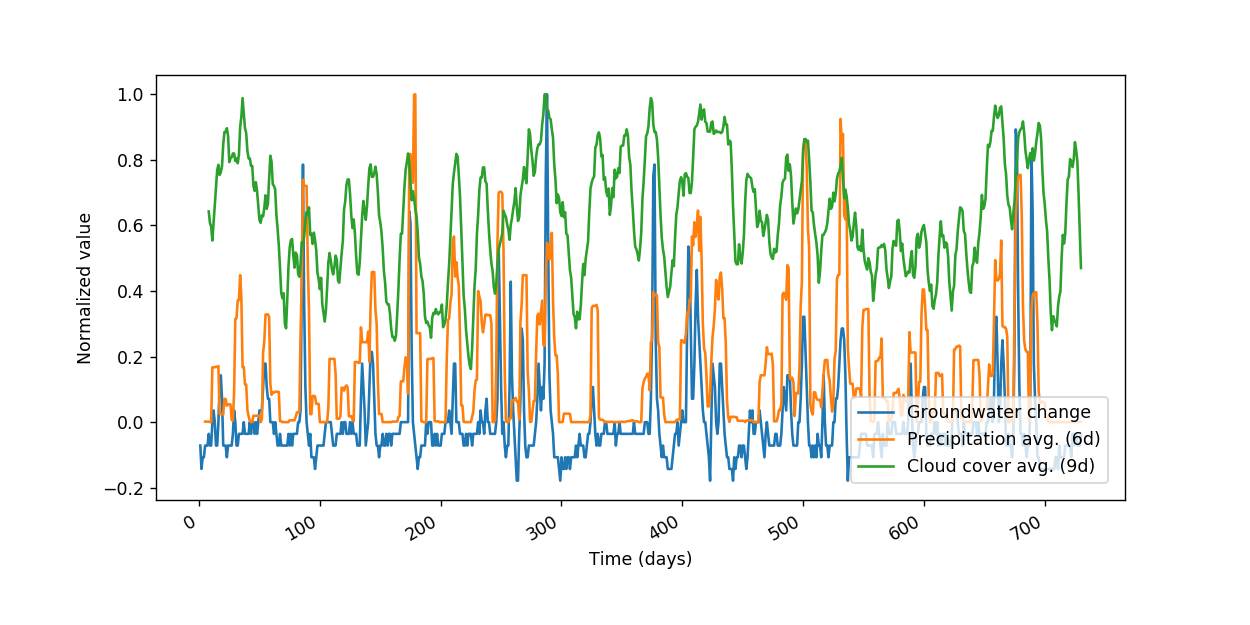

In [28]:
# ploted corelated quantities
fig, ax = plt.subplots(); fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(len(dnew['DValue'])), dnew['DValue'] / np.max(np.abs(dnew['DValue']),axis=0), label="Groundwater change");
ax.plot(range(len(dnew['DValue'])), dnew['Percipitation_average_6d'] / np.max(np.abs(dnew['Percipitation_average_6d']),axis=0), label="Precipitation avg. (6d)");
ax.plot(range(len(dnew['DValue'])), dnew['CloudCover_average_9d'] / np.max(np.abs(dnew['CloudCover_average_9d']),axis=0), label="Cloud cover avg. (9d)");
ax.legend(loc=4, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Normalized value')
plt.show();

In [29]:
fig.savefig('correlations.png', dpi=300)

In [45]:
#create new data frame for chosen colerated quantities
data_corelated = pd.DataFrame()
corelated = ['Percipitation_average_6d',
             'Percipitation_average_10d',
             'Percipitation_average_25d',
             'CloudCover_average_9d',
             'Sun_duration_average_9d'
            ]
data_corelated['DValue'] = copy.deepcopy(dnew['DValue'])

for corelated in corelated:
    data_corelated[corelated] = copy.deepcopy(dnew[corelated])


In [46]:
data_corelated

,DValue,Percipitation_average_3d,Percipitation_average_10d,Percipitation_average_25d,CloudCover_average_9d,Sun_duration_average_9d
Date,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,-0.02,NaN,NaN,NaN,NaN,NaN
2015-01-03,-0.04,0.000000e+00,NaN,NaN,NaN,NaN
2015-01-04,-0.03,6.666667e-02,NaN,NaN,NaN,NaN
2015-01-05,-0.03,6.666667e-02,NaN,NaN,NaN,NaN
2015-01-06,-0.02,6.666667e-02,NaN,NaN,NaN,NaN
2015-01-07,-0.02,0.000000e+00,NaN,NaN,NaN,NaN
2015-01-08,-0.02,0.000000e+00,NaN,NaN,NaN,NaN
2015-01-09,-0.01,0.000000e+00,NaN,NaN,62.111111,2.700000


# Learn

In [47]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import Normalizer

from sklearn.metrics import mean_squared_error, r2_score

In [48]:
#create arrays x (corelated) and y ('DValue')
#y = dnew['Value']
y = data_corelated['DValue']
y = y.values.astype(np.float)[30:]
X = data_corelated.iloc[:, 1:len(corelated)]
X= X.values.astype(np.float)[30:]

In [74]:
(y.shape,X.shape)

((701,), (701, 5))

In [66]:
(np.isnan(y).any(),np.isnan(X).any())

(False, False)

In [88]:
#choose regressor

regressor = linear_model.LinearRegression();
regressor = DecisionTreeRegressor();
regressor = RandomForestRegressor();
regressor = SVR();
regressor = GradientBoostingRegressor();

In [89]:
#predict
predicted = cross_val_predict(regressor, X, y, cv = 3)

<IPython.core.display.Javascript object>


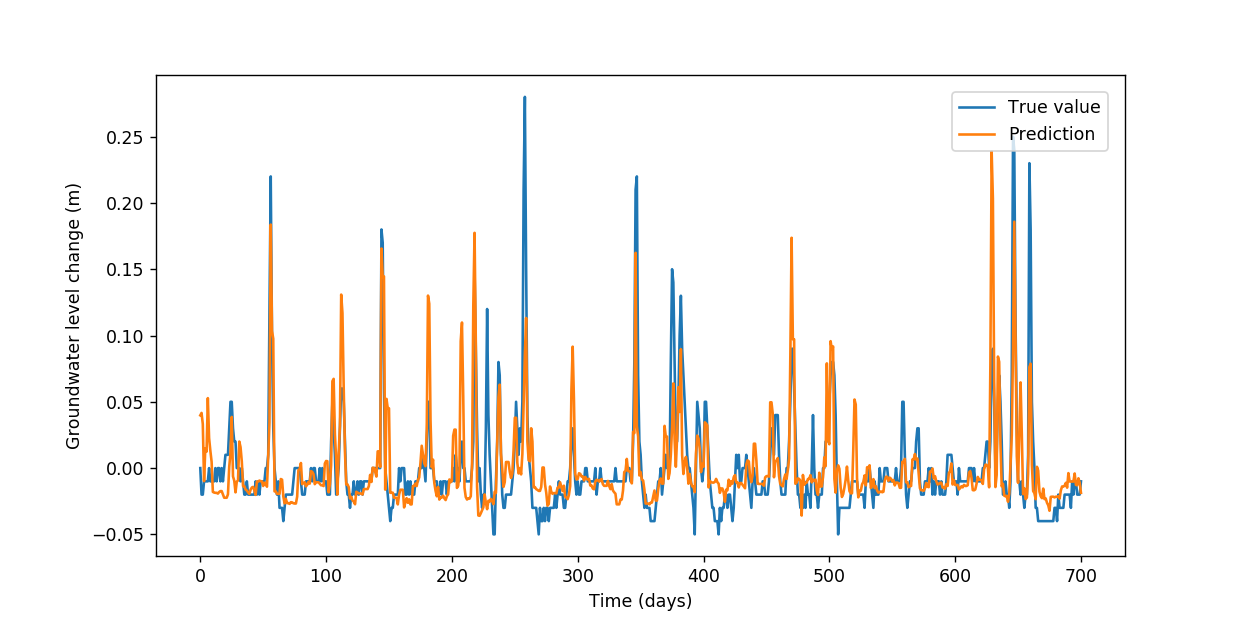

In [90]:
#plot predicted values and real value
fig, ax = plt.subplots(); 
#fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(len(y)), y, label="True value")
ax.plot(range(len(y)), predicted, label="Prediction");
ax.legend(loc=1, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Groundwater level change (m)')
plt.show();

In [39]:
#fig.savefig('prediction.png', dpi=300)

In [91]:
#evaluate results

mse = mean_squared_error(y, predicted)
r2 = r2_score(y, predicted);
(mse, r2)

(0.0008329225701572472, 0.4818733926099934)

In [92]:
#evaluation for all regressors
regressor_list = (linear_model.LinearRegression(),
            DecisionTreeRegressor(),
            RandomForestRegressor(),
            SVR(),
            MLPRegressor(),
            GradientBoostingRegressor())

for regressor in regressor_list:
    predicted = cross_val_predict(regressor, X, y, cv = 3)
    mse = mean_squared_error(y, predicted)
    r2 = r2_score(y, predicted);
    print(mse, r2)

0.0008060611896038017 0.4985827440846943
0.001273609129814684 0.2077405497041097
0.0009275962910128244 0.4229807949623776
0.0068007334436515484 -3.2304543941674027
4.38055556930543 -2723.9620516095856
0.0008314924846007075 0.4827629895596204


In [93]:
#sum
value = ds['Value']
value = value.values.astype(np.float)[30:]

predicted_value = []
predicted_value.append(value[0])
n=1
for i in predicted[1:]:
    predicted_value.append(predicted_value[n-1] + i)
    n += 1

<IPython.core.display.Javascript object>


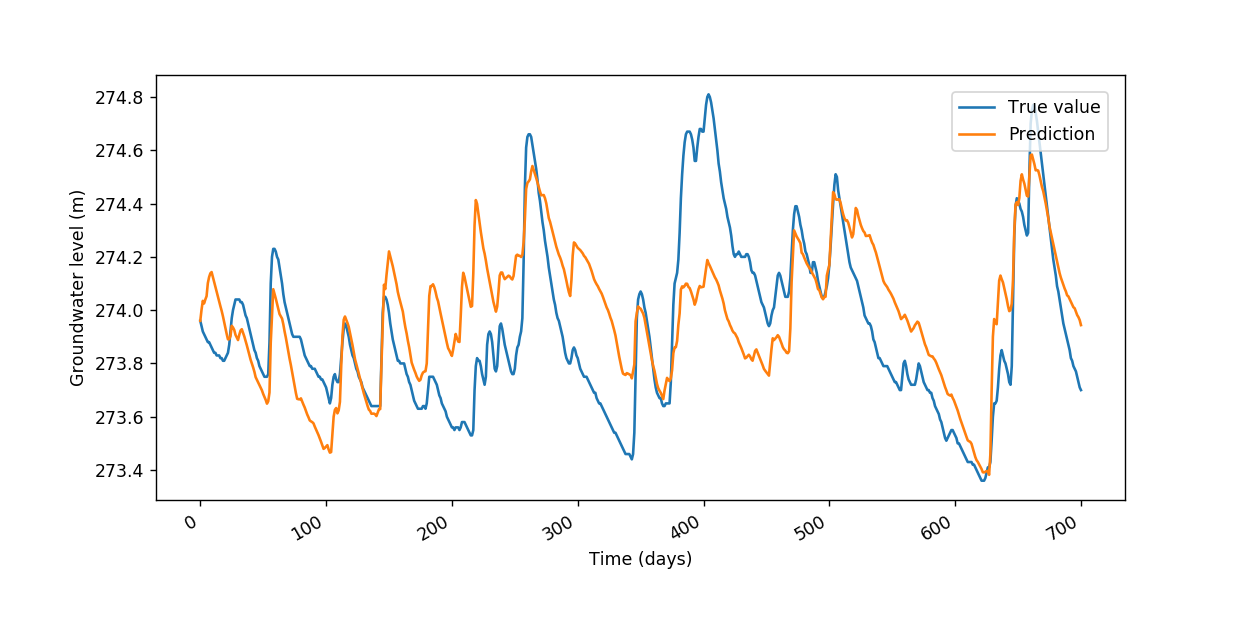

In [94]:
fig, ax = plt.subplots(); fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(len(value)), value, label="True value");
ax.plot(range(len(value)), predicted_value, label="Prediction");
ax.legend(loc=1, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Groundwater level (m)')
plt.show();

In [44]:
#fig.savefig('prediction_cum.png', dpi=300)